https://www.mortality.org/

In [ ]:
# done: trailing 12 month average instead of annual average for box plot

# done: incorporate japanese population data
# done: back fill UN birth by month data for periods that aren't available in HMD
# done: insert NaN values for months that don't have any data (ensure blank areas show up in heatmap)
# done: scale tick marks with figure size (label size?) for visibility

# TODO: explicit NaN coloring in heatmap (background color?)


# TODO: convert to script, create template to display outputs

# TODO: normalize months by year to get seasonality of births

# TODO: un-normalized heatmap of daily births (not scaled to population)
# TODO: seasonality heatmap

# TODO: stack multiple countries on top of each other? modify existing plotting function?
# TODO: explore d3 heatmap using the same data



Notes for 1882 in Iceland:
https://pmc.ncbi.nlm.nih.gov/articles/PMC5782203/

In [53]:
from pathlib import Path
import pandas as pd
# unless I'm interpolating datetime values or working with time series data, polars is better.
import polars as pl
import numpy as np
# data fetching
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
# for logarithmic color scales
from matplotlib.colors import LogNorm, Normalize
# transforms are used for text positioning
from matplotlib import transforms
# for grid layout
from matplotlib.gridspec import GridSpec
# matplotlib theming
from aquarel import load_theme
theme = load_theme("gruvbox_light")
theme.apply()
# customize font in visualizations
mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['figure.facecolor'] = '#fafaf9'

In [54]:
# list of countries with at least some data to plot;
# not all of these have enough data to be really interesting,
# and several will need to have either births or population filled from other sources.
countries_and_labels = [
    ('AUS', 'Australia'),
    ('AUT', 'Austria'),
    ('BEL', 'Belgium'),
    ('BGR', 'Bulgaria'),
    ('CAN', 'Canada'),
    ('CHE', 'Switzerland'),
    ('CZE', 'Czechia'),
    ('DEUTE', 'East Germany'),
    ('DEUTNP', 'Germany'),
    ('DEUTW', 'West Germany'),
    ('DNK', 'Denmark'),
    ('ESP', 'Spain'),
    ('EST', 'Estonia'),
    ('FIN', 'Finland'),
    ('FRATNP', 'France'),
    ('GBR_NIR', 'Northern Ireland'),
    ('GBRTENW', 'England and Wales'),
    ('GBR_NP', 'United Kingdom'),
    ('GBR_SCO', 'Scotland'),
    ('GRC', 'Greece'),
    ('HKG', 'Hong Kong'),
    ('HUN', 'Hungary'),
    ('IRL', 'Ireland'),
    ('ISL', 'Iceland'),
    ('ISR', 'Israel'),
    ('ITA', 'Italy'),
    ('JPN', 'Japan'),
    ('KOR', 'South Korea'),
    ('LTU', 'Lithuania'),
    ('LUX', 'Luxembourg'),
    ('LVA', 'Latvia'),
    ('NLD', 'Netherlands'),
    ('NOR', 'Norway'),
    ('NZL_NP', 'New Zealand'),
    ('POL', 'Poland'),
    ('PRT', 'Portugal'),
    ('RUS', 'Russia'),
    ('SVK', 'Slovakia'),
    ('SVN', 'Slovenia'),
    ('SWE', 'Sweden'),
    ('UKR', 'Ukraine'),
    ('USA', 'United States'),
]



The UN also [provides data on births by month](https://data.un.org/Data.aspx?d=POP&f=tableCode%3A55). They don't provide a direct link to the CSV file, as far as I can tell, but if you go to the page and click on the "Download Data" button, you can get a zipped CSV file. The same holds true for the UN's [population data, which is broken out by year, age group, sex, urban/rural residence for each country](https://data.un.org/Data.aspx?d=POP&f=tableCode%3A22). We can parse both UN datasets into cleaned and filtered data frames; unlike the HMD data, redistributing the UN data is not a problem.

In [55]:
def load_jpn_pop_data():
    """
    Assumes that the file is in the same directory as this script.
    The CSV file was parsed from R source code and is in wide format, which we'll melt into long format.
    Source: `fmsb` R package by Minato Nakazawa, who processed data from:
        Statistics Bureau, Ministry of Internal Affairs and Communications: Population Census, 1888-2020.
    """
    file_path = Path('jpop.csv')
    df = pd.read_csv(file_path)
    # melt into long format
    df = df.melt(id_vars=['Sex', 'Year'], var_name='Age', value_name='Population')
    return df

def process_jpop_data(jpop: pd.DataFrame) -> pd.DataFrame:
    # remove 85+ age and convert to int
    jpop = jpop[jpop['Age'] != '85+'].copy()
    jpop['Age'] = jpop['Age'].astype(int)
    # filter to women of childbearing age (15-44) so we can calculate the general fertility rate
    # note that F/M are capitalized in this data source
    jpop = jpop[(jpop['Age'] >= 15) & (jpop['Age'] <= 44) & (jpop['Sex'] == 'F')].copy()
    


jpop = load_jpn_pop_data()
jpop.head()

,Sex,Year,Age,Population
0,F,1888,0,520477
1,M,1888,0,539962
2,F,1893,0,514991
3,M,1893,0,531884
4,F,1898,0,599251


In [56]:
jpop['Age'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67',
       '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '80', '81', '82', '83', '84', '85+'], dtype=object)

In [57]:
# assumes location relative to current file/working directory
hmd_data_dir = Path('hmd_data')
# these loaders make assumptions about the file structure relative to this notebook.
# Human Mortality Database files need to be manually downloaded due to terms of use.
def load_births_file(country_code: str) -> pd.DataFrame:
    file_path = hmd_data_dir / f'{country_code}birthbymonth.txt'
    return pd.read_csv(file_path, low_memory=False)

def load_population_file(country_code: str) -> pd.DataFrame:
    file_path = hmd_data_dir / f'{country_code}pop.txt'
    return pd.read_csv(file_path, low_memory=False)

# country_code = 'FRATNP'
# country_name = 'France'
# country_code = 'ITA'
# country_name = 'Italy'
# country_code = 'NOR'
# country_name = 'Norway'
# country_code = 'JPN'
# country_name = 'Japan'
# country_code = 'SWE'
# country_name = 'Sweden'
country_code = 'ESP'
country_name = 'Spain'

pop = load_population_file(country_code)
births = load_births_file(country_code)

# only use data that was deemed good enough to be used in mortality project's life table database
births = births[births['LDB'] == 1].copy()
# filter out totals and select needed columns
births = births[~births['Month'].isin(['TOT', 'UNK'])].copy()
births = births[['Year', 'Month', 'Births']].copy()
births['Month'] = births['Month'].astype(int)
births['Births'] = births['Births'].astype(float)
# when there's more than one RefCode/etc. for a given month/year, average the births across sources
births = births.groupby(['Year', 'Month'])['Births'].mean().reset_index()

# remove 'TOT' and 'UNK' rows from population
pop = pop[~pop['Age'].isin(['TOT', 'UNK'])].copy()
# convert age to int
pop['Age'] = pop['Age'].astype(int)
# filter to women of childbearing age (15-44) so we can calculate the general fertility rate
pop = pop[(pop['Age'] >= 15) & (pop['Age'] <= 44) & (pop['Sex'] == 'f')].copy()
# only use data that was deemed good enough to be used in mortality project's life table database
pop = pop[pop['LDB'] == 1].copy()
# when there's more than one RefCode per year, average the population estimates
pop = pop.groupby(['Year', 'Month', 'Age'])['Population'].mean().reset_index()


In [58]:
# compute total population by year and month
pop_by_year = pop.groupby(['Year', 'Month'])['Population'].sum().reset_index()

# create datetime index for resampling
pop_by_year['date'] = pd.to_datetime(pop_by_year[['Year', 'Month']].assign(Day=1))
pop_by_year = pop_by_year.set_index('date').sort_index()

# resample to monthly frequency and interpolate missing values
pop_interpolated = pop_by_year[['Population']].resample('MS').first()
pop_interpolated['Population'] = pop_interpolated['Population'].interpolate(method='linear')

# extract Year and Month from datetime index, then reset index
pop_interpolated['Year'] = pop_interpolated.index.year
pop_interpolated['Month'] = pop_interpolated.index.month
pop_interpolated = pop_interpolated.reset_index(drop=True)

# merge the two dataframes on the year and month columns
births = births.merge(pop_interpolated[['Year', 'Month', 'Population']], on=['Year', 'Month'], how='left')

# create datetime index for births to calculate days in month
births['date'] = pd.to_datetime(births[['Year', 'Month']].assign(Day=1))

# sort by date to ensure chronological order for backfilling
births = births.sort_values('date').reset_index(drop=True)

# backfill population data up to 6 months later
# bfill propagates values backward in time (uses next valid value to fill gaps)
births['Population'] = births['Population'].bfill(limit=6)

# use pandas datetime functionality to get days in month
births['days_in_month'] = pd.PeriodIndex(births['date'], freq='M').days_in_month

# compute births per day
births['births_per_day'] = births['Births'] / births['days_in_month']

# general fertility rate is births per year per thousand women of childbearing age
# so we'll call this one "daily_fertility_rate" and scale it up to 100k
births['daily_fertility_rate'] = (births['births_per_day'] / births['Population']) * 1e5

# filter out rows with null values
births = births[births['daily_fertility_rate'].notna()].copy()

# drop the temporary date column
births = births.drop(columns='date')

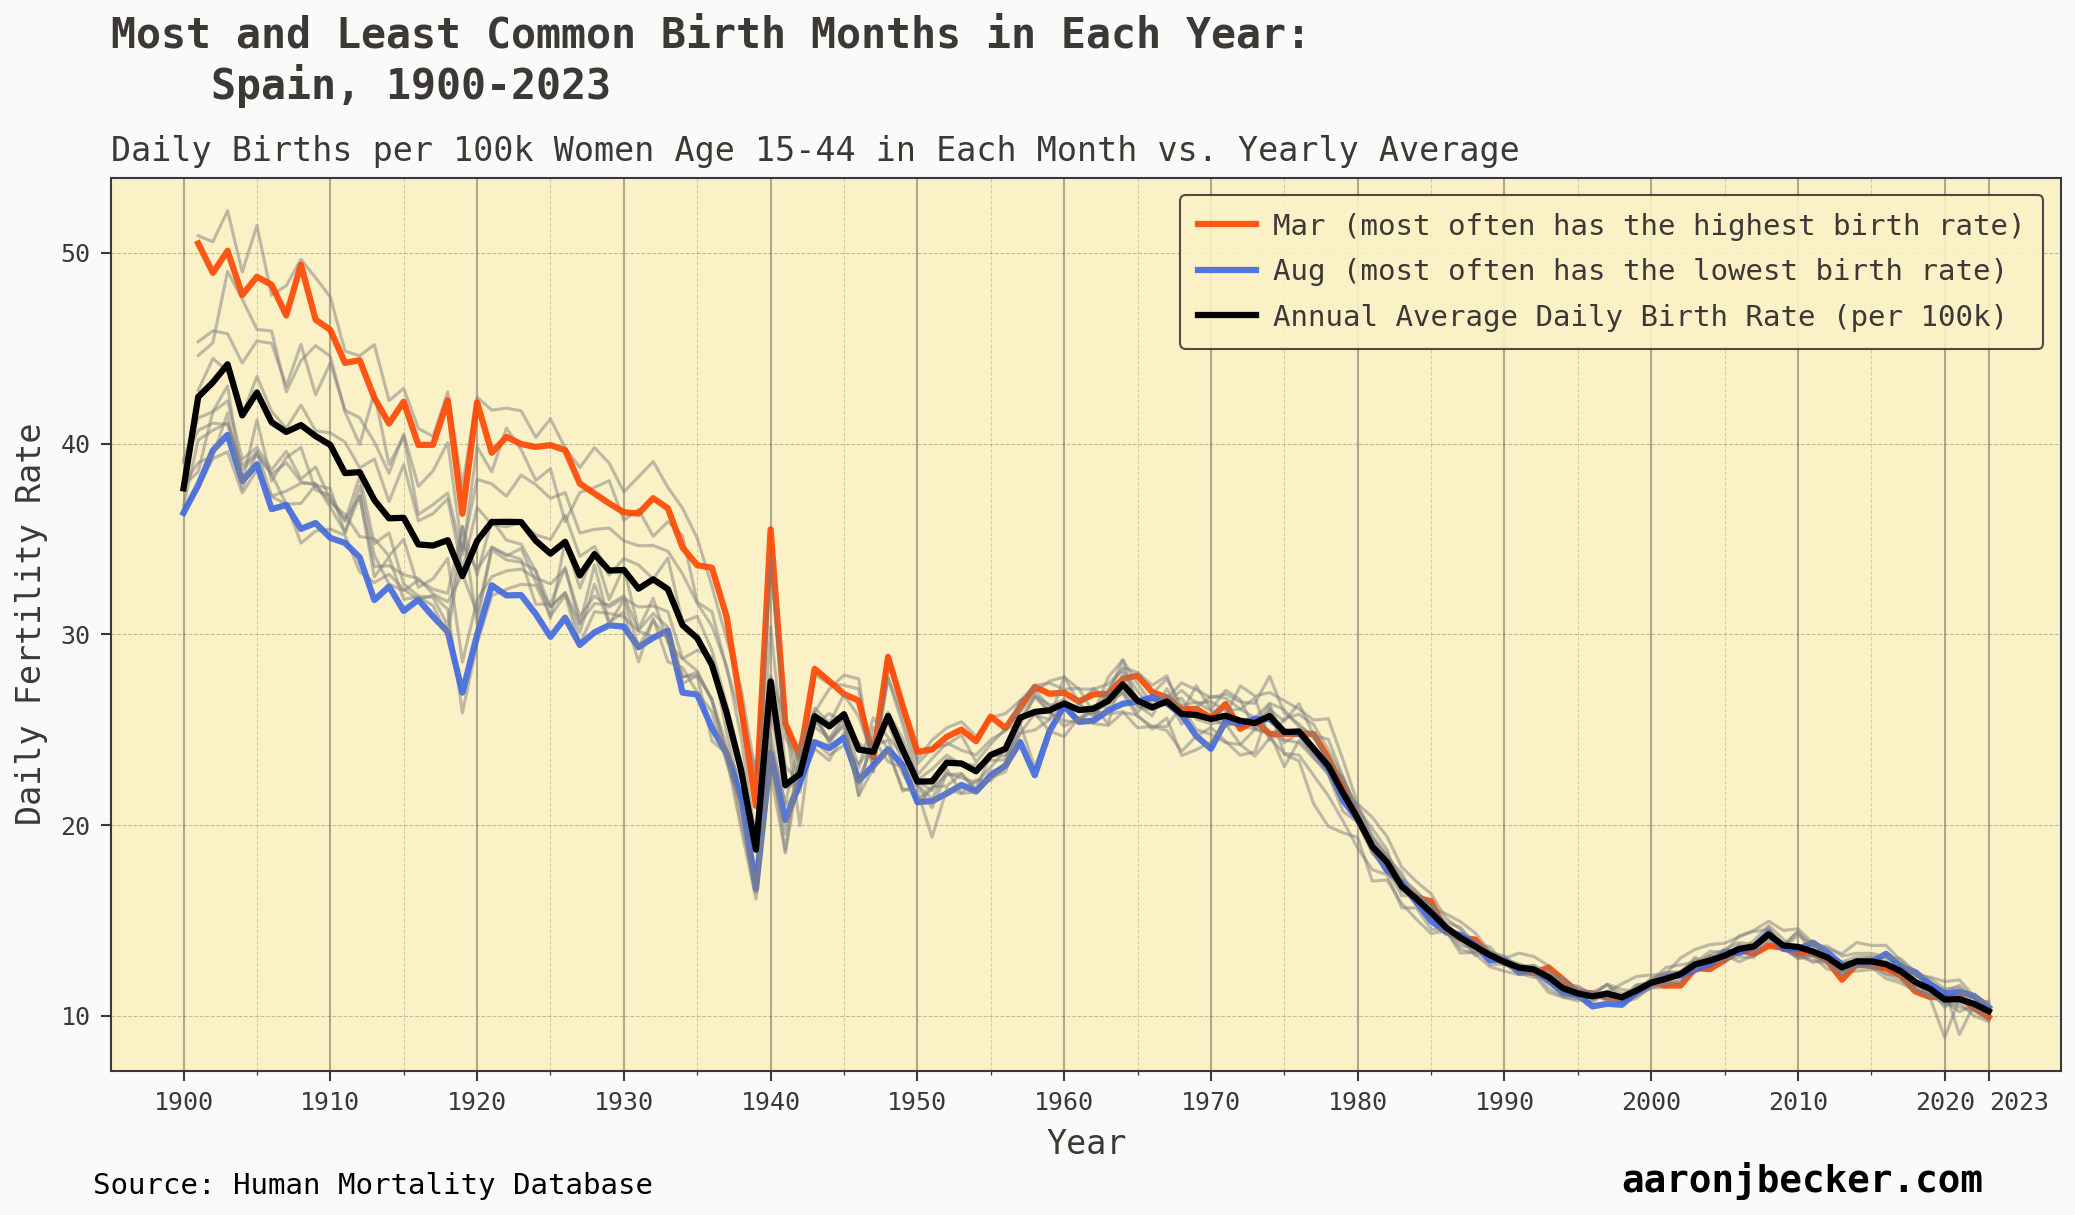

In [69]:
# Diagnostic plot: Monthly fertility rates over time with ranking analysis
# Compute yearly averages
yearly_avg = births.groupby('Year')['daily_fertility_rate'].mean().reset_index()
yearly_avg.columns = ['Year', 'yearly_avg_rate']

# Merge yearly averages back to births dataframe
births_with_avg = births.merge(yearly_avg, on='Year', how='left')

# Rank months within each year (1 = highest rate, 12 = lowest rate)
# Use method='min' to handle ties consistently
births_with_avg['rank'] = births_with_avg.groupby('Year')['daily_fertility_rate'].rank(method='min', ascending=False)

# Calculate total rank for each month (sum of ranks across all years)
month_total_ranks = births_with_avg.groupby('Month')['rank'].sum().reset_index()
month_total_ranks.columns = ['Month', 'total_rank']

# Identify months to highlight
# Lowest total rank = best overall performer (highlight in red)
# Highest total rank = worst overall performer (highlight in blue)
top_ranked_month = month_total_ranks.loc[month_total_ranks['total_rank'].idxmin(), 'Month']
bottom_ranked_month = month_total_ranks.loc[month_total_ranks['total_rank'].idxmax(), 'Month']

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)

# Month names for labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot each month's series
for month in range(1, 13):
    month_data = births_with_avg[births_with_avg['Month'] == month].sort_values('Year')
    
    params = {
        'linewidth': 3,
        'alpha': 0.9
    }
    # Determine color based on total rank
    if month == top_ranked_month:
        params['color'] = 'orangered'        
        params['label'] = f"{month_names[month-1]} (most often has the highest birth rate)"
    elif month == bottom_ranked_month:
        params['color'] = 'royalblue'
        params['label'] = f"{month_names[month-1]} (most often has the lowest birth rate)"
    else:
        params['color'] = 'gray'
        params['linewidth'] = 1.5
        params['alpha'] = 0.5
        params['label'] = '_nolegend_'  # Exclude from legend
    
    ax.plot(month_data['Year'], month_data['daily_fertility_rate'], 
            **params)

# Plot yearly average as darker line
yearly_avg_sorted = yearly_avg.sort_values('Year')
ax.plot(yearly_avg_sorted['Year'], yearly_avg_sorted['yearly_avg_rate'], 
        color='black', linewidth=3, label='Annual Average Daily Birth Rate (per 100k)', zorder=10)

# Format x-axis with year ticks and labels
# Get the range of years in the data
years = births_with_avg['Year'].unique()
years = np.sort(years)
min_year = years.min()
max_year = years.max()

# Formatting
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Daily Fertility Rate', fontsize=16)
text = ax.set_title('Daily Births per 100k Women Age 15-44 in Each Month vs. Yearly Average', fontsize=16, loc='left')
ex = text.get_window_extent()
x, y = text.get_position()
t = transforms.offset_copy(text._transform, y=ex.height + 20, units='dots')
ax.text(x, y, f'Most and Least Common Birth Months in Each Year:\n    {country_name}, {min_year}-{max_year}', fontsize=20, weight='bold', transform=t, va='bottom')


# Determine tick spacing based on data range
year_range = max_year - min_year
if year_range <= 30:
    major_tick_spacing = 5
    minor_tick_spacing = 1
elif year_range <= 60:
    major_tick_spacing = 10
    minor_tick_spacing = 2
else:
    major_tick_spacing = 10
    minor_tick_spacing = 5

# Set major ticks (every N years)
major_ticks = np.arange(min_year, max_year + 1, major_tick_spacing)
# Ensure first and last years are included
first_off_cycle = False
last_off_cycle = False
if min_year not in major_ticks:
    major_ticks = np.append(min_year, major_ticks)
    first_off_cycle = True
if max_year not in major_ticks:
    major_ticks = np.append(major_ticks, max_year)
    last_off_cycle = True
major_ticks = np.sort(np.unique(major_ticks))

# Set minor ticks (every M years)
minor_ticks = np.arange(min_year, max_year + 1, minor_tick_spacing)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
tick_labels = ax.set_xticklabels(major_ticks, fontsize=12)
if first_off_cycle:
    tick_labels[0].set_horizontalalignment('right')
if last_off_cycle:
    tick_labels[-1].set_horizontalalignment('left')

# Add grid lines (major and minor)
ax.grid(True, which='major', alpha=0.4, linestyle='-', linewidth=1)
ax.grid(True, which='minor', alpha=0.2, linestyle='--', linewidth=0.5)
ax.grid(True, which='major', axis='y', alpha=0.3, linestyle='--', linewidth=0.5)

# Add legend
ax.legend(loc='best', fontsize=14, framealpha=0.9)

# Source notes
fig.text(0.05, -0.01, 'Source: Human Mortality Database', fontsize=14, color='black', ha='left', va='bottom')

# website link
fig.text(0.95, -0.01, 'aaronjbecker.com', fontsize=18, weight='bold', color='black', ha='right', va='bottom')

plt.tight_layout()
plt.show()


In [64]:
# Function to generate nicely rounded tick values
def get_rounded_ticks(vmin, vmax, target_num_ticks=5):
    """
    Generate nicely rounded tick values (multiples of 2, 5, or 10) 
    between vmin and vmax, aiming for approximately target_num_ticks ticks.
    """
    data_range = vmax - vmin
    # Estimate step size for target number of ticks
    rough_step = data_range / (target_num_ticks - 1)
    
    # Find the order of magnitude
    magnitude = 10 ** np.floor(np.log10(rough_step))
    normalized_step = rough_step / magnitude
    
    # Try different step sizes (2, 5, 10) and choose the one that gives
    # the best number of ticks closest to target_num_ticks
    best_step = None
    best_num_ticks = 0
    best_tick_values = None
    
    for nice_multiplier in [2, 5, 10]:
        step = nice_multiplier * magnitude
        
        # Round vmin down to nearest multiple of step
        tick_min = np.floor(vmin / step) * step
        
        # Round vmax up to nearest multiple of step
        tick_max = np.ceil(vmax / step) * step
        
        # Generate ticks
        candidate_ticks = np.arange(tick_min, tick_max + step/2, step)
        
        # Filter to only include ticks within [vmin, vmax]
        candidate_ticks = candidate_ticks[(candidate_ticks >= vmin) & (candidate_ticks <= vmax)]
        
        # Sort and remove duplicates
        candidate_ticks = np.unique(np.sort(candidate_ticks))
        num_ticks = len(candidate_ticks)
        
        # Prefer steps that give us a good number of ticks (3-7 ticks)
        # Prefer smaller steps (5 over 10) when they give similar results
        if num_ticks >= 3 and num_ticks <= 7:
            if best_step is None:
                best_step = step
                best_num_ticks = num_ticks
                best_tick_values = candidate_ticks
            elif abs(num_ticks - target_num_ticks) < abs(best_num_ticks - target_num_ticks):
                # Better match to target
                best_step = step
                best_num_ticks = num_ticks
                best_tick_values = candidate_ticks
            elif abs(num_ticks - target_num_ticks) == abs(best_num_ticks - target_num_ticks):
                # Same distance from target, prefer smaller step (5 over 10)
                if nice_multiplier < (best_step / magnitude):
                    best_step = step
                    best_num_ticks = num_ticks
                    best_tick_values = candidate_ticks
    
    # If no good step found, use the default logic
    if best_step is None:
        if normalized_step <= 2:
            nice_multiplier = 2
        elif normalized_step <= 5:
            nice_multiplier = 5
        else:
            nice_multiplier = 10
        step = nice_multiplier * magnitude
        tick_min = np.floor(vmin / step) * step
        tick_max = np.ceil(vmax / step) * step
        best_tick_values = np.arange(tick_min, tick_max + step/2, step)
        best_tick_values = best_tick_values[(best_tick_values >= vmin) & (best_tick_values <= vmax)]
        best_tick_values = np.unique(np.sort(best_tick_values))
    
    return best_tick_values


# Function to find first even year for tick spacing
def get_first_even_year(first_yr, spacing):
    if spacing == 2:
        return first_yr if first_yr % 2 == 0 else first_yr + 1
    elif spacing == 5:
        remainder = first_yr % 10
        if remainder == 0 or remainder == 5:
            return first_yr
        elif remainder < 5:
            return first_yr - remainder + 5
        else:
            return first_yr - remainder + 10
    else:  # spacing == 10
        remainder = first_yr % 10
        if remainder == 0:
            return first_yr
        else:
            return ((first_yr // 10) + 1) * 10

TODO: insert NaN values in heatmap for missing data (cf NLD)
TODO: gray background or coloring for missing data (cf NLD)

In [ ]:
def build_heatmap_figure(births, country_name, years_per_row=35, colormap=None, log_scale_colors=True):
    """
    Build a heatmap of the daily fertility rate by month and year.
    :param births: pd.DataFrame, the births data
    :param country_name: str, the name of the country
    :param years_per_row: int, Maximum number of years per row (subplot). If data exceeds this, it will wrap to new rows
    :return: plt.Figure, the heatmap figure
    """
    if colormap is None:
        colormap = 'YlOrRd'

    # prepare data for heatmap: pivot to have months as rows, years as columns (horizontal orientation)
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # pivot the data: months as rows, years as columns
    heatmap_data = births.pivot_table(
        index='Month', 
        columns='Year', 
        values='daily_fertility_rate',
        aggfunc='first'
    )

    # reorder months to match 1-12 order (Jan=1, Dec=12)
    heatmap_data = heatmap_data.reindex(index=range(1, 13))

    # ensure years are sorted
    heatmap_data = heatmap_data.sort_index(axis=1)

    # ============================================================================
    # PLOTTING PARAMETERS
    # ============================================================================
    # Get min and max values for colorbar (use full dataset)
    # Ensure vmin is positive for logarithmic normalization
    vmin = max(np.nanmin(heatmap_data.values), 1e-6)  # use small positive value if min is too close to zero
    vmax = np.nanmax(heatmap_data.values)

    if log_scale_colors:
        color_norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        color_norm = Normalize(vmin=vmin, vmax=vmax)

    # determine if we need to wrap into multiple subplots
    years = heatmap_data.columns.values
    num_years = len(years)
    first_year = years[0]
    last_year = years[-1]

    # Split years into chunks if needed
    if num_years > years_per_row:
        # Calculate number of chunks
        num_chunks = (num_years + years_per_row - 1) // years_per_row  # ceiling division
        
        # Create list of year ranges for each chunk
        year_chunks = []
        for i in range(num_chunks):
            start_idx = i * years_per_row
            end_idx = min((i + 1) * years_per_row, num_years)
            year_chunks.append(years[start_idx:end_idx])
    else:
        # Single subplot
        year_chunks = [years]
        num_chunks = 1

    # Define aspect ratio (width:height ratio for a reference subplot)
    # determine width based on number of years per row: we want approximately square heatmap cells
    base_width = max(5, years_per_row / 2.5)
    base_height = 5 # this is admittedly a magic number

    # Calculate figure dimensions
    # Each subplot row has base_height, plus space for title and margins
    num_rows = num_chunks
    total_height = num_rows * base_height + 2  # extra space for title and spacing

    # Total width: base width for reference years_per_row, plus space for colorbars
    total_width = base_width + 2  # extra space for colorbars on sides

    # Create figure with appropriate size
    fig = plt.figure(figsize=(total_width, total_height), dpi=150)

    # ============================================================================
    # FONT SCALING
    # ============================================================================
    # For single row cases, use larger base fonts and scale based on both width and height
    # For multi-row cases, scale based on figure dimensions
    if num_rows == 1:
        # Single row: use larger base fonts and scale based on width and height
        # Reference: assume ~15 inch width and ~7 inch height for typical single row
        ref_width = 7.0
        ref_height = 7.0
        
        # Scale based on both dimensions (geometric mean to balance width and height)
        width_scale = total_width / ref_width
        height_scale = total_height / ref_height
        font_scale = np.sqrt(width_scale * height_scale)  # geometric mean
        font_scale = max(1.0, font_scale)  # At least 1.0
        
        # Larger base fonts for single row (since figure is wide)
        base_font_title = 24
        base_font_subtitle = 18
        base_font_subplot_title = 14
        base_font_tick_labels = 11
        base_font_cbar_tick = 11
        base_font_cbar_labels = 11
        base_font_cbar_title = 11
    else:
        # Multi-row: scale based on figure area
        ref_height = base_height + 2  # reference height for single row
        ref_area = base_width * ref_height  # reference figure area
        actual_area = total_width * total_height  # actual figure area
        
        # Scale factor based on area ratio (square root to maintain proportional scaling)
        font_scale = np.sqrt(actual_area / ref_area)
        
        # Base font sizes for multi-row case
        base_font_title = 20
        base_font_subtitle = 14
        base_font_subplot_title = 12
        base_font_tick_labels = 9
        base_font_cbar_tick = 8
        base_font_cbar_labels = 8
        base_font_cbar_title = 8

    # Scaled font sizes
    font_title = base_font_title * font_scale
    font_subtitle = base_font_subtitle * font_scale
    font_subplot_title = base_font_subplot_title * font_scale
    font_tick_labels = base_font_tick_labels * font_scale
    font_cbar_tick = base_font_cbar_tick * font_scale
    font_cbar_labels = base_font_cbar_labels * font_scale
    font_cbar_title = base_font_cbar_title * font_scale

    # Define margins and spacing for GridSpec (GridSpec will handle the rest)
    left_margin = 0.1
    right_margin = 0.1
    top_margin = 0.15
    bottom_margin = 0.08
    hspace = 0.05 * num_rows + 0.1
    wspace = 0.1

    # Function to determine tick spacing for a given number of years
    def get_tick_spacing(num_years_chunk):
        if num_years_chunk <= 40:
            return 2
        elif num_years_chunk <= 100:
            return 5
        else:
            return 10

    # Function to plot colorbar
    def plot_cbar(cax, im, title=None):
        cb = plt.colorbar(im, cax=cax, orientation='vertical')
        cb.outline.set_edgecolor('black')
        
        # Generate nicely rounded tick values
        tick_values = get_rounded_ticks(vmin, vmax, target_num_ticks=7)
        
        # Set ticks and format to avoid scientific notation
        cb.set_ticks(tick_values)
        # Use a formatter that displays decimal values without scientific notation
        # Format based on whether values are integers or need decimals
        def format_tick(x, p):
            if abs(x) < 1e-6:
                return '0'
            if abs(x - int(x)) < 1e-6:
                return f'{int(x)}'
            else:
                return f'{x:.1f}'
        
        # Use custom formatter to prevent scientific notation
        cb.ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_tick))
        # cb.ax.yaxis.set_minor_formatter(mpl.ticker.FuncFormatter(format_tick))
        cax.minorticks_off()
        
        cax.tick_params(which='major', labelsize=font_cbar_tick, length=4, width=1)
        # cax.tick_params(which='minor', labelsize=font_cbar_tick, length=2, width=0.5)
        cax.yaxis.set_ticks_position('left')
        cax.yaxis.set_label_position('left')
        cax.yaxis.tick_left()
        
        # Add min and max value labels at the ends
        cax.text(0.5, -0.02, f'{vmin:.1f}', 
                transform=cax.transAxes, ha='center', va='top',
                fontsize=font_cbar_labels, color='black')
        cax.text(0.5, 1.02, f'{vmax:.1f}', 
                transform=cax.transAxes, ha='center', va='bottom',
                fontsize=font_cbar_labels, color='black')
        
        if title:
            # Add vertical title to the right of the tick labels
            t = transforms.offset_copy(cax.transAxes, fig=fig, x=2*font_cbar_title, units='points')
            cax.text(1.0, 0.5, title,
                    ha='center', va='center',
                    fontsize=font_cbar_title, color='black', rotation=270, transform=t)

    # Find the maximum number of years in any chunk to size the heatmap column
    max_chunk_years = max(len(chunk) for chunk in year_chunks)
    
    # Calculate width ratios for GridSpec columns
    # Heatmap column width should be proportional to max years, colorbar is fixed narrow
    # Use relative ratios - GridSpec will normalize them within available space
    heatmap_width_ratio = max_chunk_years  # proportional to max years
    colorbar_width_ratio = 1  # fixed narrow column
    
    # Create main GridSpec with 2 columns: heatmap area + colorbar column
    # GridSpec handles all positioning, margins, and spacing automatically
    main_gs = GridSpec(num_rows, 2, figure=fig,
                       left=left_margin, right=1.0 - right_margin,
                       top=1.0 - top_margin, bottom=bottom_margin,
                       hspace=hspace, wspace=wspace,
                       width_ratios=[heatmap_width_ratio, colorbar_width_ratio])
    
    # Plot each chunk as a subplot
    axes = []
    images = []
    for row_idx, chunk_years in enumerate(year_chunks):
        # Extract data for this chunk
        chunk_data = heatmap_data[chunk_years]
        
        # Create heatmap subplot - GridSpec positions it automatically
        ax = fig.add_subplot(main_gs[row_idx, 0])
        
        # Adjust heatmap width to match actual data (left-aligned)
        # Calculate width ratio for this specific chunk
        chunk_width_ratio = len(chunk_years) / max_chunk_years
        if chunk_width_ratio < 1.0:
            pos = ax.get_position()
            new_width = pos.width * chunk_width_ratio
            ax.set_position([pos.x0, pos.y0, new_width, pos.height])
        
        axes.append(ax)
        
        # Create heatmap with logarithmic normalization
        im = ax.imshow(chunk_data.values, interpolation='nearest', cmap=colormap, aspect='auto', 
                    norm=color_norm)
        images.append(im)
        
        # Styling
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_color('black')
        
        # Calculate tick spacing for this chunk
        chunk_num_years = len(chunk_years)
        tick_spacing = get_tick_spacing(chunk_num_years)
        
        chunk_first_year = chunk_years[0]
        chunk_last_year = chunk_years[-1]
        
        if num_rows > 1:
            # Add left-aligned title showing year range for this subplot
            ax.set_title(f'{chunk_first_year}-{chunk_last_year}', 
                        fontsize=font_subplot_title, color='black', loc='left', pad=10, weight='bold')
        
        # Find first even year for this chunk
        first_even_year = get_first_even_year(chunk_first_year, tick_spacing)
        
        # Create tick years for this chunk
        tick_years_chunk = np.arange(first_even_year, chunk_last_year + 1, tick_spacing)
        
        # Track whether first and last years are at regular intervals
        first_at_regular_interval = chunk_first_year in tick_years_chunk
        last_at_regular_interval = chunk_last_year in tick_years_chunk
        
        # Ensure first and last years are included
        if not first_at_regular_interval:
            tick_years_chunk = np.append(chunk_first_year, tick_years_chunk)
        if not last_at_regular_interval:
            tick_years_chunk = np.append(tick_years_chunk, chunk_last_year)
        
        # Sort and filter to only include years that exist in this chunk
        tick_years_chunk = np.sort(tick_years_chunk)
        tick_years_chunk = tick_years_chunk[np.isin(tick_years_chunk, chunk_years)]
        tick_positions_chunk = [np.where(chunk_years == year)[0][0] for year in tick_years_chunk]
        
        # Set x-axis ticks and labels
        ax.set_xticks(tick_positions_chunk)    
        labels = ax.set_xticklabels(tick_years_chunk, fontsize=font_tick_labels, color='black', rotation=0, ha='center', va='top')
        # Only adjust horizontal alignment if first/last labels are not at regular intervals
        if len(labels) > 0 and not first_at_regular_interval:
            labels[0].set_ha('right')
        if len(labels) > 1 and not last_at_regular_interval:
            labels[-1].set_ha('left')
        ax.xaxis.tick_bottom()
        
        # Set x-axis minor ticks
        if tick_spacing == 10:
            minor_spacing = 2
        else:
            minor_spacing = 1
        
        minor_tick_positions = np.arange(0, len(chunk_years), minor_spacing)
        ax.set_xticks(minor_tick_positions, minor=True)
        
        # Configure tick parameters
        ax.tick_params(axis='x', which='major', length=4, width=1, bottom=True, top=False)
        ax.tick_params(axis='x', which='minor', length=2, width=0.5, bottom=True, top=False)
        
        # Set y-axis ticks and labels (month names)
        ax.set_yticks(np.arange(12))
        ax.set_yticklabels(month_names, fontsize=font_tick_labels, color='black', va='center')
        ax.tick_params(axis='y', labelleft=True, labelright=False, left=True, right=False)
        
        # Create colorbar subplot in the right column (aligned across all rows)
        cax = fig.add_subplot(main_gs[row_idx, 1])
        title = 'Daily Births\nper 100k Women Age 15-44'
        plot_cbar(cax, im, title=title)

    # TOP TEXT
    # place this relative to the first (top) axis, starting with bottom-most text and working upwards
    top_ax = axes[0]
    ex = top_ax.get_window_extent()
    # use the bbox before it's transformed, since that's in figure coordinates rather than pixels.
    x, y = ex._bbox.x0, ex._bbox.y1
    t = transforms.offset_copy(fig.transFigure, fig=fig, y=40, units='points')
    if num_rows > 1 and log_scale_colors:
        # add note about color bar being logarithmic
        text = fig.text(x, y,
                'Same logarithmic color scale used throughout.',
                fontsize=font_subplot_title, color='black', ha='left', va='bottom', style='italic', transform=t)        
        ex = text.get_window_extent()
        x, y = text.get_position()
        t = transforms.offset_copy(text._transform, y=ex.height + 30, units='dots')
    # Subtitle (below main title)
    text = fig.text(x, y,
            'Daily Births Per 100k Women (Age 15-44)',
            fontsize=font_subtitle, color='black', ha='left', va='bottom', transform=t)
    ex = text.get_window_extent()
    x, y = text.get_position()
    t = transforms.offset_copy(text._transform, y=ex.height + 20, units='dots')
    # main title
    linebreak = "\n    " if num_rows > 1 else " "
    text = fig.text(x, y,
            f'Monthly Fertility Rate,{linebreak}{country_name}: {first_year} to {last_year}', 
            fontsize=font_title, color='black', weight='bold', ha='left', va='bottom', transform=t)

    # BOTTOM TEXT
    bottom_ax = axes[-1]
    ex = bottom_ax.get_window_extent()
    x, y = ex._bbox.x0, ex._bbox.y0
    space_from_bottom = -3 * font_subtitle
    t = transforms.offset_copy(fig.transFigure, fig=fig, y=space_from_bottom, x=-10, units='points')
    # Source notes
    fig.text(x, y, 'Source: Human Mortality Database', fontsize=font_subplot_title, color='black', ha='left', va='bottom', transform=t)
    # website link: relative to last colorbar
    last_cbar = fig.axes[-1]
    ex = last_cbar.get_window_extent()
    x, y = ex._bbox.x1, ex._bbox.y0
    t = transforms.offset_copy(fig.transFigure, fig=fig, y=space_from_bottom, x=10, units='points')
    fig.text(x, y, 'aaronjbecker.com', fontsize=font_subtitle, weight='bold', color='black', ha='right', va='bottom', transform=t)

    # mention log color scale above cbar axis if this is single row
    if num_rows == 1 and log_scale_colors:
        t = transforms.offset_copy(fig.transFigure, fig=fig, y=font_subplot_title * 1.5, x=10, units='points')
        fig.text(ex._bbox.x1, ex._bbox.y1, 'Color scale is logarithmic.', fontsize=font_subplot_title, color='black', ha='right', va='bottom', transform=t, style='italic')

    return fig

In [66]:
# fig = build_heatmap_figure(births, country_name, colormap='turbo', log_scale_colors=False)
# plt.show()

[Turbo](https://research.google/blog/turbo-an-improved-rainbow-colormap-for-visualization/) seems like a good color map choice for this data because it's designed from the ground up to allow users to appreciate subtle value differences. If we use turbo do we even need logarithmic scaling?

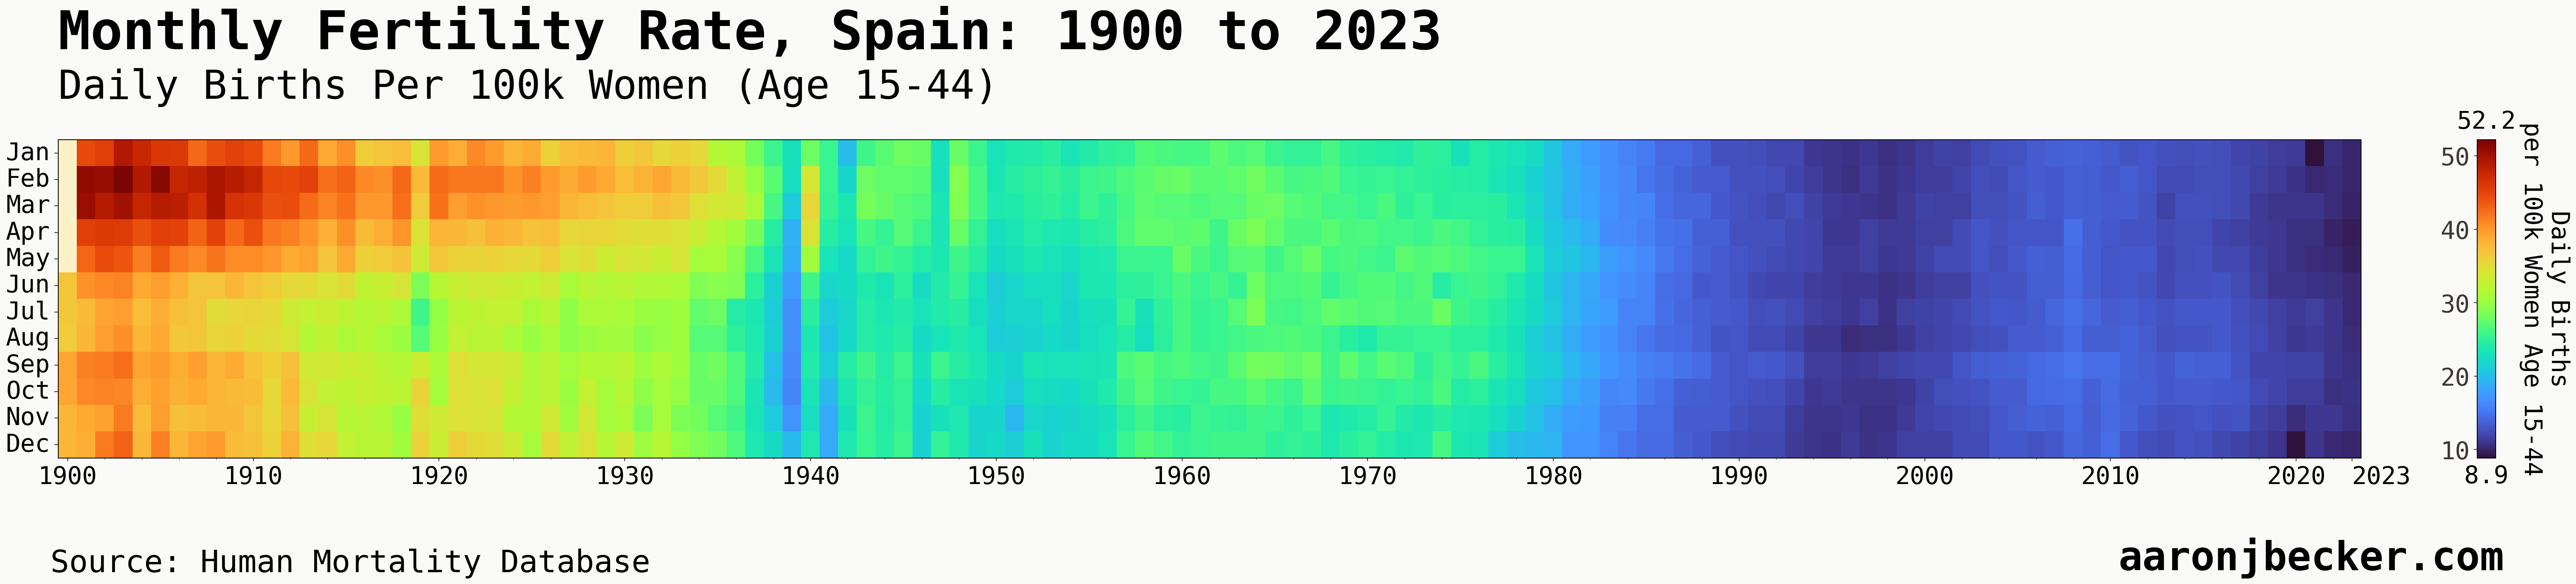

In [67]:
fig = build_heatmap_figure(births, country_name, years_per_row=births['Year'].nunique(), colormap='turbo', log_scale_colors=False)
plt.show()

In [68]:
# fig = build_heatmap_figure(births, country_name, years_per_row=births['Year'].nunique(), colormap='YlOrRd', log_scale_colors=True)
# plt.show()